In [1]:
cd /Users/eliasimos/Documents/eth2_challenge_notes_and_data/last\ pull

/Users/eliasimos/Documents/eth2_challenge_notes_and_data/last pull


In [2]:
ls

Final_V3.ipynb
clients_per_index.csv
double_vote_epoch.csv
double_votes_within_slots.csv
doublevotes_within_slot.csv
grouping-analysis.ipynb
merged_group_finality.csv
new_validators_by_indentifier_master.csv
new_validators_by_indentifier_master.csv.zip
proposer_effectiveness.csv
same_slot_twice_attested.csv
val_ids.csv
validator_performance.csv
validator_ratios.csv
validator_ratios_updates.csv


In [3]:
# load useful packages
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
sns.set()

In [4]:
m_finality = pd.read_csv('merged_group_finality.csv')
m_finality.tail()

,Unnamed: 0,lag_0,lag_1,lag_2,lag_3+,Unnamed: 0.1,0,validators_entered_cumul,validators_exited_cumul,validators_active,validator_req_ffg,validator_req_ffg_per_slot
14341,14341,43069.0,17158.0,0.0,0.0,14568,14568,76950.0,6272.0,70678.0,47119.0,1472.46875
14342,14342,39000.0,14809.0,0.0,0.0,14569,14569,76954.0,6274.0,70680.0,47120.0,1472.50000
14343,14343,43455.0,12516.0,0.0,0.0,14570,14570,76958.0,6274.0,70684.0,47123.0,1472.59375
14344,14344,44616.0,12307.0,0.0,0.0,14571,14571,76962.0,6274.0,70688.0,47125.0,1472.65625
14345,14345,42671.0,0.0,0.0,0.0,14572,14572,76972.0,6274.0,70698.0,47132.0,1472.87500


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f800f9a0550>,
      dtype=object)

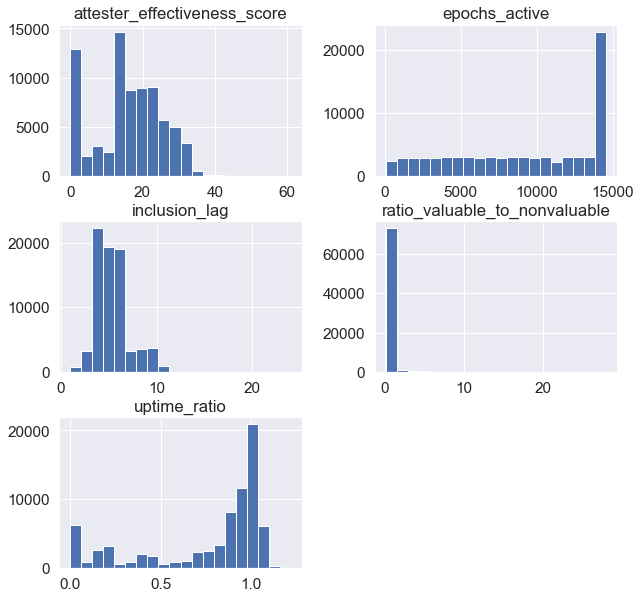

In [30]:
# load up abbreviated table of validator performance
att_eff = pd.read_csv('validator_ratios.csv')
att_eff = att_eff.rename(columns={'Unnamed: 0':'validatorindex'})
# create effectiveness score
att_eff['attester_effectiveness_score'] = att_eff['uptime_ratio']*100/att_eff['inclusion_lag']
# tidy up
att_eff_abrv = att_eff[[ 'uptime_ratio', 'inclusion_lag', 'epochs_active','ratio_valuable_to_nonvaluable','attester_effectiveness_score']]
# plot histogram!
att_eff_abrv.hist(bins = 20, figsize = (10,10))

In [6]:
# load up validators by identifier
val_id = pd.read_csv('val_ids.csv')
val_id.tail()

,Unnamed: 0,identifier,validatorindex,client_identifier
69038,69038,Rocketpool/Wouimbly/Paolo,78844,unknown
69039,69039,Rocketpool/Wouimbly/Paolo,78845,unknown
69040,69040,Rocketpool/Wouimbly/Paolo,78846,unknown
69041,69041,Bison_Trails,75347,prysm
69042,69042,Bison_Trails,75190,prysm


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8029bbe3d0>,
      dtype=object)

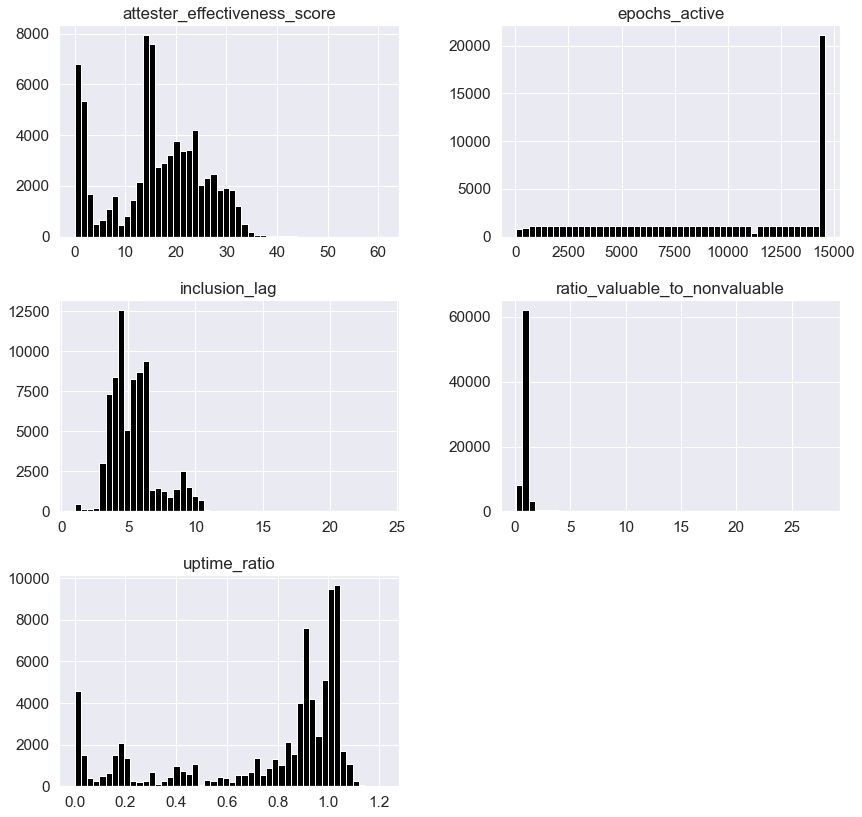

In [10]:
# merge for group performance - by identifier
val_group_perf = pd.merge(left=att_eff, right=val_id, how='left', left_on='validatorindex', right_on='validatorindex')
val_group_perf1 = val_group_perf[['uptime_ratio', 'inclusion_lag', 'ratio_valuable_to_nonvaluable', 'epochs_active', 'attester_effectiveness_score']]
val_group_perf1.hist(color = 'black', bins = 50, figsize = (14,14))

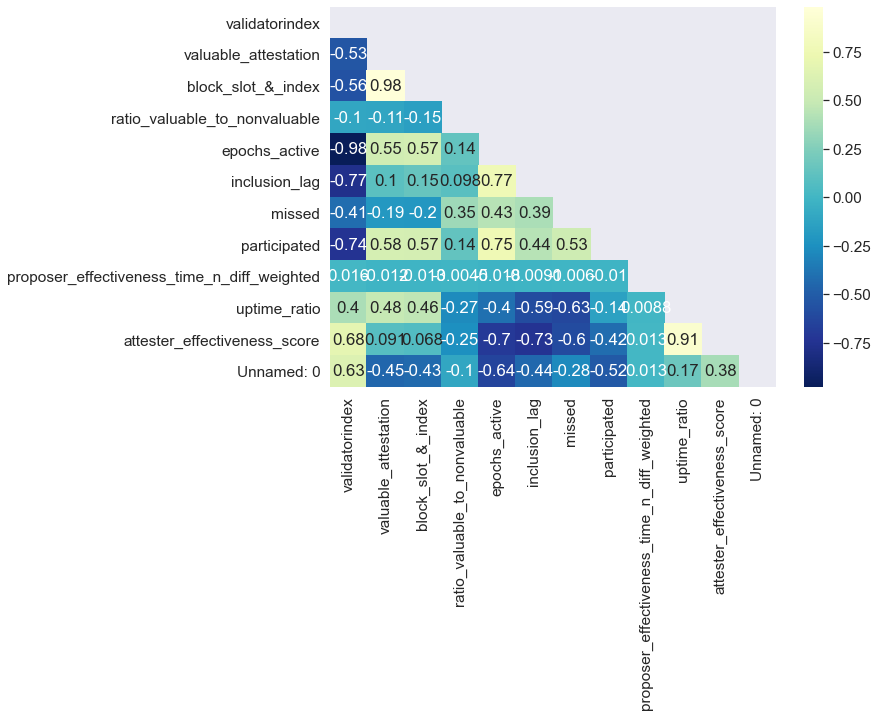

In [31]:
# heatmap of the correlation matrix of key categories by group
ax = val_group_perf.corr()    
plt.subplots(figsize=(10,7))
sns.set(font_scale=1.4)
mask = np.zeros_like(ax, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(ax, cmap="YlGnBu_r",  annot=True, mask=mask)

In [52]:
val_group_perf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76228 entries, 0 to 76227
Data columns (total 14 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   validatorindex                               76228 non-null  int64  
 1   valuable_attestation                         76227 non-null  float64
 2   block_slot_&_index                           75576 non-null  float64
 3   ratio_valuable_to_nonvaluable                75575 non-null  float64
 4   epochs_active                                76228 non-null  int64  
 5   inclusion_lag                                76227 non-null  float64
 6   missed                                       76228 non-null  float64
 7   participated                                 76228 non-null  float64
 8   proposer_effectiveness_time_n_diff_weighted  76226 non-null  float64
 9   uptime_ratio                                 76227 non-null  float64
 10

In [54]:
test_group = val_group_perf.loc[(val_group_perf['client_identifier'] == 'prysm')]
test_group.head(1)

,validatorindex,valuable_attestation,block_slot_&_index,ratio_valuable_to_nonvaluable,epochs_active,inclusion_lag,missed,participated,proposer_effectiveness_time_n_diff_weighted,uptime_ratio,attester_effectiveness_score,Unnamed: 0,identifier,client_identifier
2509,2509,13813.0,15574.0,0.886927,14572,6.293781,0.0,11.0,0.000069,0.947914,15.061118,7828.0,B - 0x00241,prysm


count    734.000000
mean       1.040761
std        0.205125
min        0.400000
25%        0.938736
50%        0.964018
75%        1.005011
max        1.538889
Name: ratio_valuable_to_nonvaluable, dtype: float64

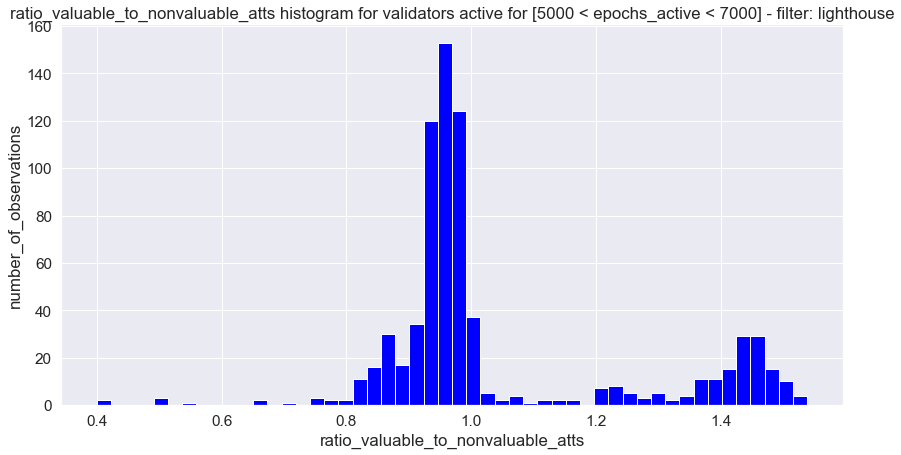

In [72]:
# filter for condition
test_group = val_group_perf.loc[(val_group_perf['epochs_active'] > 5000)  & (val_group_perf['epochs_active'] < 7000) & (val_group_perf['ratio_valuable_to_nonvaluable'] < 2) & (val_group_perf['client_identifier'] == 'prysm')]
test_group['ratio_valuable_to_nonvaluable'].hist(color = 'blue', bins = 50, figsize = (14,7))
pl.xlabel("ratio_valuable_to_nonvaluable_atts")
pl.ylabel("number_of_observations")
pl.title("ratio_valuable_to_nonvaluable_atts histogram for validators active for [5000 < epochs_active < 7000] - filter: lighthouse")
test_group['ratio_valuable_to_nonvaluable'].describe()

In [15]:
# filter for client groupings
client_view = pd.pivot_table(val_group_perf, index=["client_identifier"], values=["ratio_valuable_to_nonvaluable", "inclusion_lag", "uptime_ratio", 'epochs_active'], aggfunc='mean')
client_view.index.name = None
#create new column with index
client_view['attester_effectiveness_score'] = client_view['uptime_ratio']*100/client_view['inclusion_lag']
client_view = client_view.sort_values(by=['attester_effectiveness_score'], ascending = False)
client_view#.drop(client_view.index[1])

,epochs_active,inclusion_lag,ratio_valuable_to_nonvaluable,uptime_ratio,attester_effectiveness_score
prysm,9413.556964,5.233447,1.025257,0.844343,16.133601
unknown,8495.628554,5.311513,0.951150,0.765017,14.403005
teku,12853.944929,5.760508,1.115971,0.804024,13.957518
lighthouse,11272.688601,5.586792,1.055909,0.767830,13.743664
lodestar,9278.530303,5.512530,1.511817,0.575342,10.436986
nimbus,13150.953908,5.903783,1.109984,0.492953,8.349777


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80294a8e50>,
      dtype=object)

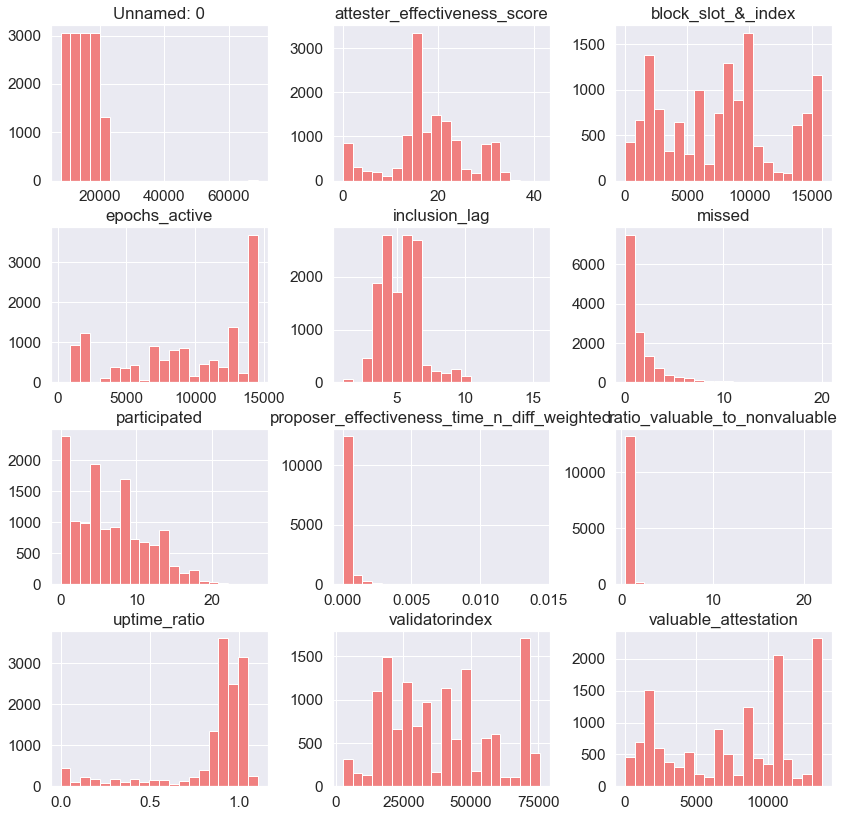

In [16]:
# prysm perf
val_group_perf_prysm = val_group_perf.loc[val_group_perf['client_identifier'] == 'prysm']
val_group_perf_prysm.hist(color = 'lightcoral', bins = 20, figsize = (14,14))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f802d9b0eb0>,
      dtype=object)

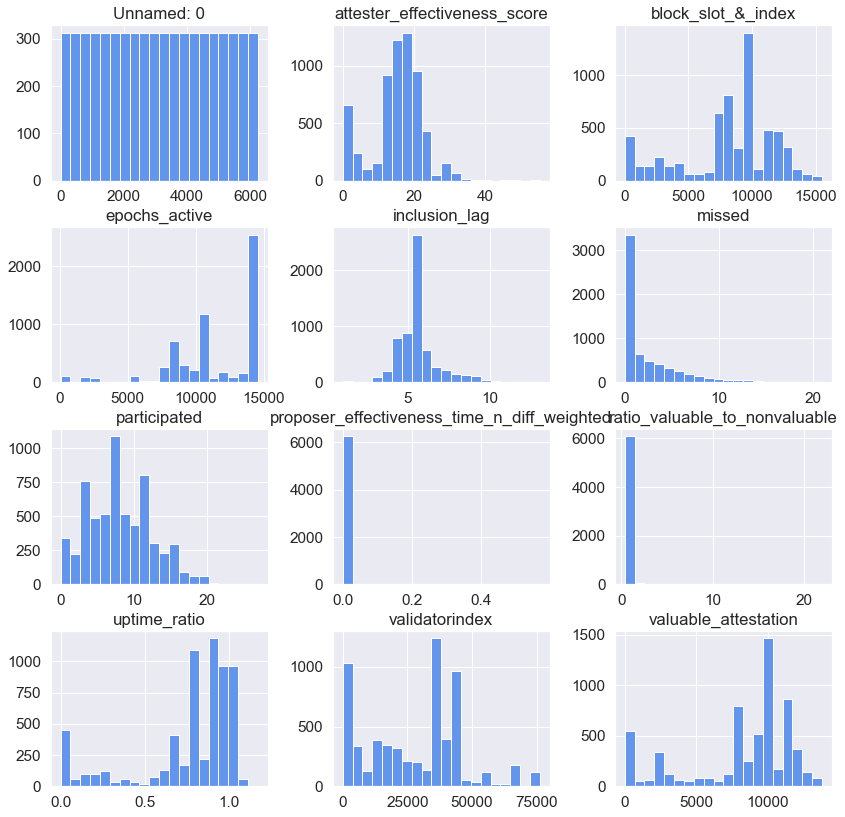

In [17]:
# lh perf
val_group_perf_lighthouse = val_group_perf.loc[val_group_perf['client_identifier'] == 'lighthouse']
val_group_perf_lighthouse.hist(color = 'cornflowerblue', bins = 20, figsize = (14,14))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f802bec7ca0>,
      dtype=object)

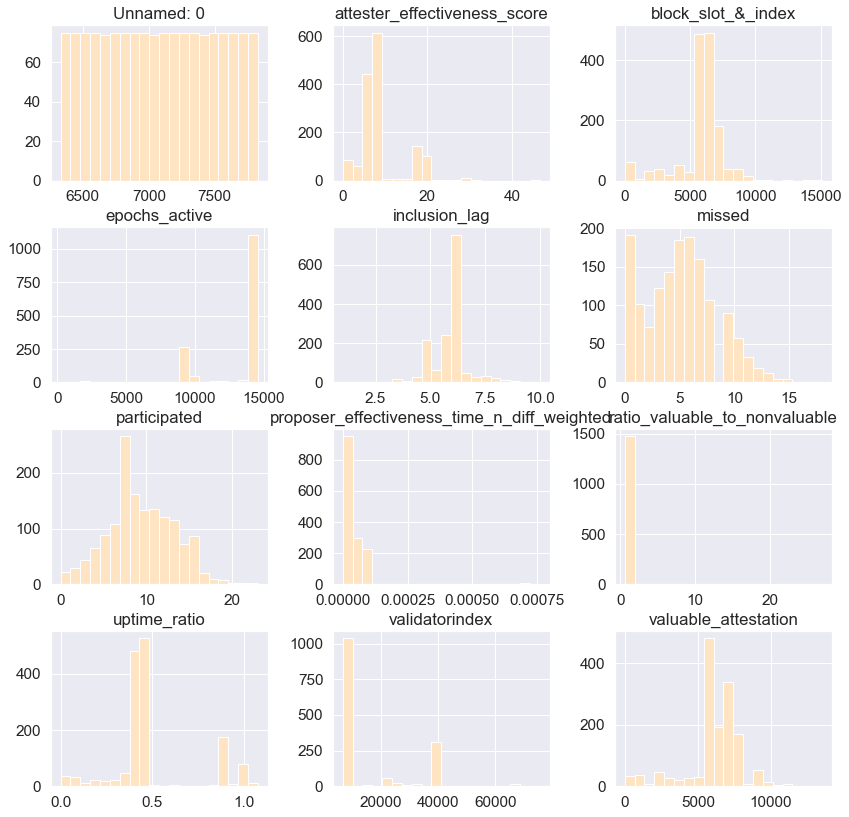

In [18]:
# nimbus perf
val_group_perf_nimbus = val_group_perf.loc[val_group_perf['client_identifier'] == 'nimbus']
val_group_perf_nimbus.hist(color = 'bisque', bins = 20, figsize = (14,14))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f802e9222e0>,
      dtype=object)

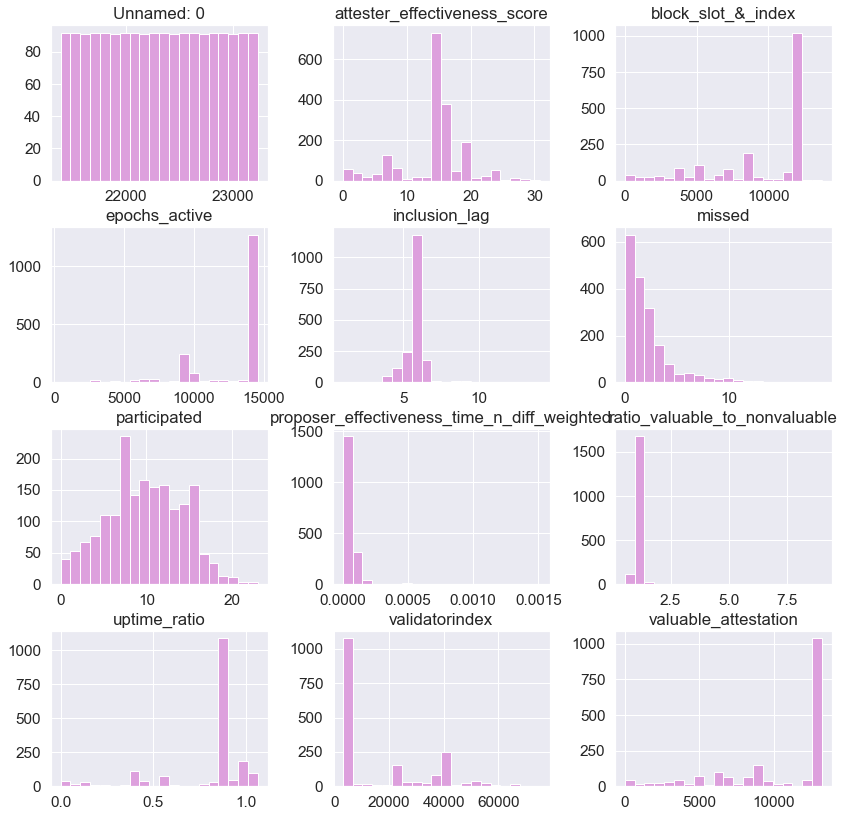

In [19]:
# teku perf
val_group_perf_teku = val_group_perf.loc[val_group_perf['client_identifier'] == 'teku']
val_group_perf_teku.hist(color = 'plum', bins = 20, figsize = (14,14))

In [23]:
group_view = pd.pivot_table(val_group_perf, index=["identifier"], values=["ratio_valuable_to_nonvaluable", "inclusion_lag", "uptime_ratio", 'epochs_active'], aggfunc='mean')
group_view.index.name = None
#create new column with index
group_view['attester_effectiveness_score'] = group_view['uptime_ratio']*100/group_view['inclusion_lag']
group_view = group_view.sort_values(by=['attester_effectiveness_score'], ascending = False)
ag = group_view.head(30)
ag

,epochs_active,inclusion_lag,ratio_valuable_to_nonvaluable,uptime_ratio,attester_effectiveness_score
Rocketpool/Wouimbly/Paolo,59.653465,3.325117,0.687151,1.065964,32.057944
eth1 - 0xd9444eef25e070fbac5636884bd3ca28bd3380b1,2007.000000,3.272147,0.899561,1.020928,31.200556
** | etherchest.com | **,2007.000000,3.258731,0.906375,1.012955,31.084329
eth1 - 0xa514fe451d039788f3d45e91b5314cdd3ee25023,333.053571,3.511956,0.663285,1.049959,29.896712
eth1 - 0x7bceb533c5244a05a0cb340d68a8a8e5ed00c991,1292.943878,3.507975,0.709905,1.036387,29.543749
eth1 - 0x9da6229dd930df1b18380376b7f9b217fcd3e113,221.321429,3.540554,0.683360,1.033228,29.182667
eth1 - 0xf571f20951998c3b68ba5b1d27aefe8c462a8f56,2264.378378,3.551857,0.699749,1.008125,28.383036
eth1 - 0x5b02d8fabb151facc3b18dd41b3b778ca80db8b2,1399.076923,3.536089,0.723458,0.993572,28.098053
eth1 - 0xadf6e7a15e590a635200c2b2fd1cc767c4791c5f,3547.478149,3.622821,0.937587,1.007425,27.807743
eth1 - 0x24cd6f1ee244562ce572dc21622c6cb150b98aa6,2859.367839,3.735836,0.754629,1.001716,26.813697


In [25]:
ag['epochs_active'].mean()

3149.191503396332

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f800f747d90>,
      dtype=object)

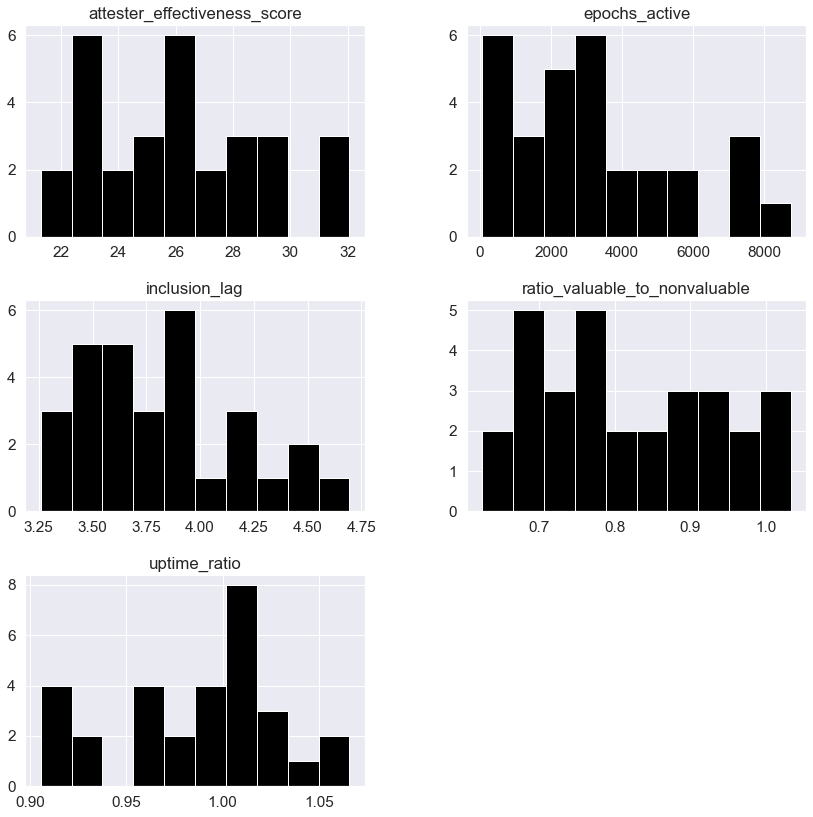

In [24]:
ag.hist(color = 'black', bins = 10, figsize = (14,14))

In [ ]:
ag